In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [3]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

nmin=0
nmax=3000

ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

#Select quality 0 Z->mumu
Zmumu_pt=MuonTree_Zmumu["muon_pt"].array()[nmin:nmax]
Zmumu_eta=MuonTree_Zmumu["muon_eta"].array()[nmin:nmax]
Zmumu_phi=MuonTree_Zmumu["muon_phi"].array()[nmin:nmax]
#And select the Z peak pairsa
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


100%|██████████| 3000/3000 [00:01<00:00, 2382.05it/s]


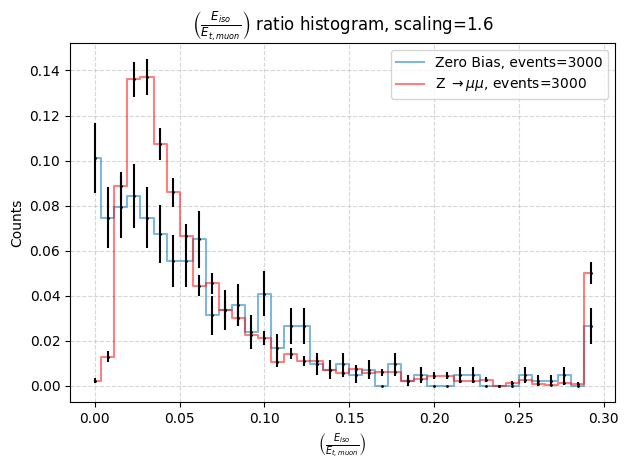

In [4]:

#Set scaling factor
scaling=1.6
#Set dr
dr_min=0.05
dr_max=0.35
#Compute isolation
res1, mask=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling, get_mask=True)
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)
#Compute number of non empty events
events1=ak.sum(ak.num(ZeroBias_pt) > 0)
events2=ak.sum(ak.num(Zmumu_pt) > 0)
#Prepare plot
data_4=[data1, data2]
bins=np.linspace(0,0.3,40)
colors=["#0072B2", "#FD0000"]
label1=f"Zero Bias, events={events1}"
label2=fr"Z $\to \mu \mu$, events={events2}"
labels=[label1, label2]
x_label=r"$\left( \frac{E_{iso}}{E_{t,muon}} \right)$"
y_label=r"Counts"
title = rf"$\left( \frac{{E_{{iso}}}}{{E_{{t,muon}}}}\right)$ ratio histogram, scaling={scaling}"
coolplot(data_4, bins, colors, labels, x_label, y_label, title)

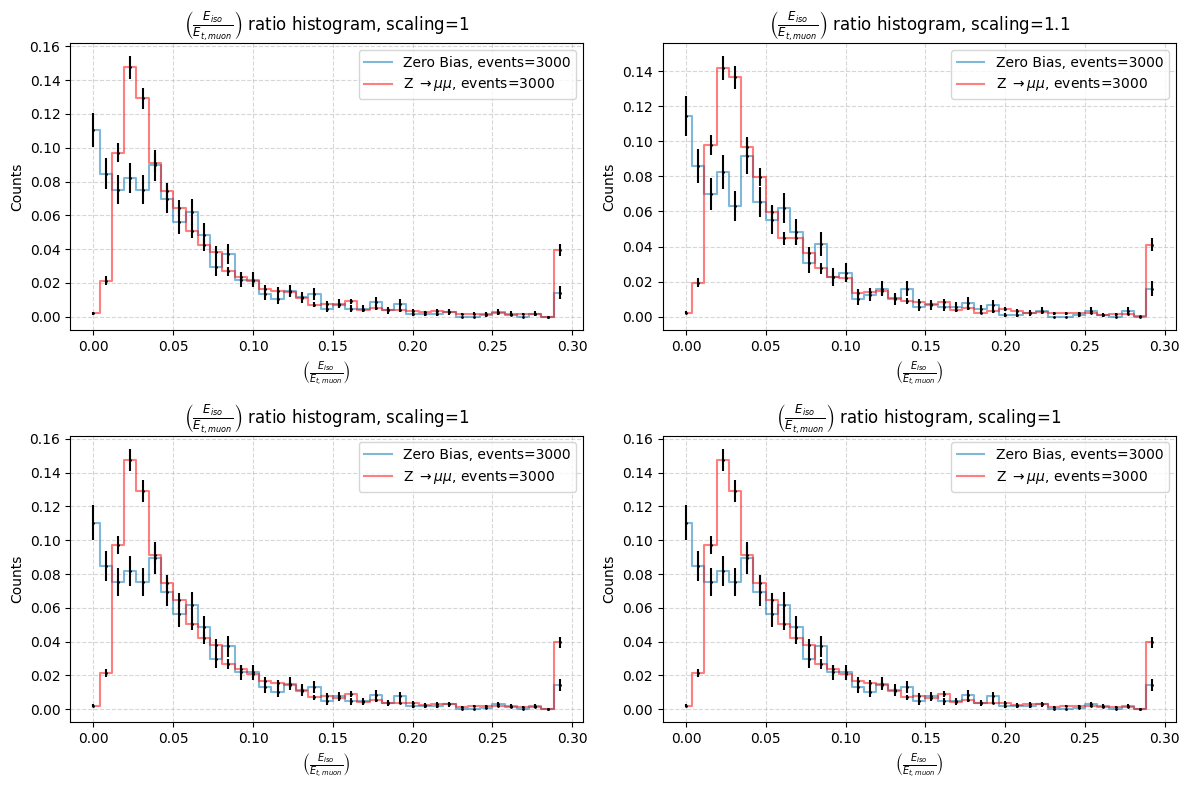

In [6]:
#------------------1st subplot------------------------------------------------------------------------------------------------
#Set scaling factor
scaling=1
#Set dr
dr_min=0.05
dr_max=0.35
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)
#Compute number of non empty events
events1=ak.sum(ak.num(ZeroBias_pt) > 0)
events2=ak.sum(ak.num(Zmumu_pt) > 0)
#Prepare plot
data_1=[data1, data2]
bins=np.linspace(0,0.3,40)
colors=["#0072B2", "#FD0000"]
label1=f"Zero Bias, events={events1}"
label2=fr"Z $\to \mu \mu$, events={events2}"
labels=[label1, label2]
x_label=r"$\left( \frac{E_{iso}}{E_{t,muon}} \right)$"
y_label=r"Counts"
title = rf"$\left( \frac{{E_{{iso}}}}{{E_{{t,muon}}}}\right)$ ratio histogram, scaling={scaling}"
#Plot
fig, axis = plt.subplots(2, 2, figsize=(12, 8))
coolplot(data_1, bins, colors, labels, x_label, y_label, title, ax=axis[0, 0])

#------------------2nd subplot------------------------------------------------------------------------------------------------
#Set scaling factor
scaling=1.1
#Set dr
dr_min=0.05
dr_max=0.35
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)
#Compute number of non empty events
events1=ak.sum(ak.num(ZeroBias_pt) > 0)
events2=ak.sum(ak.num(Zmumu_pt) > 0)
#Prepare plot
data_2=[data1, data2]
bins=np.linspace(0,0.3,40)
colors=["#0072B2", "#FD0000"]
label1=f"Zero Bias, events={events1}"
label2=fr"Z $\to \mu \mu$, events={events2}"
labels=[label1, label2]
x_label=r"$\left( \frac{E_{iso}}{E_{t,muon}} \right)$"
y_label=r"Counts"
title = rf"$\left( \frac{{E_{{iso}}}}{{E_{{t,muon}}}}\right)$ ratio histogram, scaling={scaling}"
coolplot(data_2, bins, colors, labels, x_label, y_label, title, ax=axis[0, 1])

#------------------3rd subplot------------------------------------------------------------------------------------------------
#Set scaling factor
scaling=1
#Set dr
dr_min=0.05
dr_max=0.35
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)
#Compute number of non empty events
events1=ak.sum(ak.num(ZeroBias_pt) > 0)
events2=ak.sum(ak.num(Zmumu_pt) > 0)
#Prepare plot
data_3=[data1, data2]
bins=np.linspace(0,0.3,40)
colors=["#0072B2", "#FD0000"]
label1=f"Zero Bias, events={events1}"
label2=fr"Z $\to \mu \mu$, events={events2}"
labels=[label1, label2]
x_label=r"$\left( \frac{E_{iso}}{E_{t,muon}} \right)$"
y_label=r"Counts"
title = rf"$\left( \frac{{E_{{iso}}}}{{E_{{t,muon}}}}\right)$ ratio histogram, scaling={scaling}"
coolplot(data_3, bins, colors, labels, x_label, y_label, title, ax=axis[1, 0])

#------------------4th subplot------------------------------------------------------------------------------------------------
#Set scaling factor
scaling=1
#Set dr
dr_min=0.05
dr_max=0.35
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax], scaling=scaling)
#Compute ratio
data1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)
data2=ak.flatten(res2)/ak.flatten(Zmumu_pt)
#Compute number of non empty events
events1=ak.sum(ak.num(ZeroBias_pt) > 0)
events2=ak.sum(ak.num(Zmumu_pt) > 0)
#Prepare plot
data_4=[data1, data2]
bins=np.linspace(0,0.3,40)
colors=["#0072B2", "#FD0000"]
label1=f"Zero Bias, events={events1}"
label2=fr"Z $\to \mu \mu$, events={events2}"
labels=[label1, label2]
x_label=r"$\left( \frac{E_{iso}}{E_{t,muon}} \right)$"
y_label=r"Counts"
title = rf"$\left( \frac{{E_{{iso}}}}{{E_{{t,muon}}}}\right)$ ratio histogram, scaling={scaling}"
coolplot(data_4, bins, colors, labels, x_label, y_label, title, ax=axis[1, 1])
